本示例演示了一个最常见的基金择时策略的优化过程，在本示例中，我们将演示以下内容：
- 创建一个包含均线择时策略的oeprator对象，该对象包含的策略采用内置的'DMA‘择时策略
- 创建一个Context上下文对象，通过设置context参数，实现策略的优化和回测设置
- 通过对过去15年左右的沪深300指数历史数据，对策略进行参数寻优，最终演示寻优后的结果

## Example Start 示例开始
首先我们导入qteasy模块，为了方便数据的后续处理，同时也导入bumpy和pandas模块
同时，为了在线打印图表，使用`matplotlib inline`设置图表打印模式为在线打印

In [1]:
import sys
sys.path.append('../')
import qteasy as qt
import numpy as np
import pandas as pd
%matplotlib inline

Module qteasy has been loaded successfully!, version: 0.1
tushare version: 1.2.48


### 创建Context 对象
使用`qt.Context()`创建一个context上下文对象，并进行以下设置：
- 投资回报率的对比数据采用沪深300指数
- 同时设置对比数据的数据类型为“I”

In [7]:
qt.configure(reference_asset = '512170.SH')
qt.configure(reference_asset_type = 'FD')

KeyError: 'Unrecognized kwarg=reference_asset_type'

- 设置参与投资组合创建的股票池，因为是纯择时策略，因此设置股票池中只有一个沪深300指数，同样设置资产类型为“I” 指数。
- 同时，设置投资开始日期为2002年（这个日期并不会起到实际作用，因为投资回测的实际开始日期以投资资金的起投日期开始计算）

In [3]:
cont.share_pool = '000300.SH'
cont.asset_type = 'I'
cont.invest_start = '20020101'

设置投资相关参数：
- moq为0，意味着不存在着必须买卖整数股的条件
- 默认的投资金额为10000元，投入日期为2006年4月6日
- 投资费率是一个Cost对象，以下设置意味着买入费率为千分之一点五，卖出费率为0，没有最低费用的限制，滑点为0

In [4]:
cont.moq = 0
cont.rate = qt.Cost(buy_fix=0.0, buy_rate=0.0015, buy_min=0.0,
                 sell_fix=0.0, sell_rate=0.0, sell_min=0.0,
                 slipage=0.0)

### 创建Operator对象
使用`qt.Operator()`创建Operator对象。
目前Operator对象尚不支持动态修改其成员策略，因此需要在创建对象时就指定各个策略成员。
该对象的目的是简单择时，因此timing_types设置为一个内置的DMA择时策略，选股策略为ALL，表示选择所有股票池内的投资产品，ricon_types可以选择none即可
这样这个Operator对象就创建完成了，是一个简单DMA择时策略。这个策略有三个参数，通过长、短均线的变化来产生多空仓位信号，一旦多空信号发生变化时，就意味着需要触发交易信号了。

In [5]:
op = qt.Operator(timing_types=['dma'],
                 selecting_types=['all'], ricon_types=['urgent'])

接下来是Operator策略参数的设置。
所有的参数设置都可以使用`operator.set_parameter`方法，可以同时传入多个参数
通过设置策略的opt_tag可以控制策略是否参与优化，而par_boes参数定义了策略优化时需要用到的参数空间
在此时我们并不知道对于过去15年的沪深300指数来说，最优的DMA择时参数是什么，因此可以输入几个随机的参数，进行一次回测，看看结果如何

In [6]:
op.set_parameter('t-0', opt_tag=1, par_boes=[(10, 250), (10, 250), (10, 250)])
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])
op.set_parameter('s-0', pars=(2,), sample_freq='y')

op.set_parameter(stg_id='t-0', pars=(35, 50, 25))
op.set_parameter('r-0', pars=(8, -0.1443033))

只要将运行模式设置为1，然后`qteasy.run(operator, context)`就可以开始回测了，

为了节省输出空间，我们设置print_log参数为False，关闭回测过程打印，
运行回测后，回测结果如下：

回测最终资产为1.9万元，年化收益率只有4.6%，夏普率只有0.072，收益率显著低于对比指数沪深300

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 1
      --Back-looping Mode--



../qteasy/utilfuncs.py:76: RuntimeWarning: invalid value encountered in true_divide
  return arr / s.reshape(shape)
../qteasy/utilfuncs.py:51: RuntimeWarning: invalid value encountered in less
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=0)), op)
../qteasy/utilfuncs.py:51: RuntimeWarning: divide by zero encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=0)), op)
../qteasy/utilfuncs.py:51: RuntimeWarning: invalid value encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=0)), op)


|                                  |
|          LOOPING RESULT          |
|                                  |

qteasy running mode: 1 - History back looping
time consumption for operate signal creation: 97.2ms ms
time consumption for operation back looping: 124.8ms ms

investment starts on 2006-04-03 00:00:00
ends on 2020-10-20 00:00:00
Total looped periods: 14.6 years.
operation summary:
            sell  buy  total
000300.SH    58   56    114
Total operation fee:     ¥   1,259.31
total investment amount: ¥  10,000.00
final value:             ¥  19,311.58
Total return: 193.116% 
Average Yearly return rate:  4.611%
Total reference return: 344.118% 
Average Yearly reference return rate: 10.783%
strategy performance indicators: 
alpha:               -0.061
Beta:                0.992
Sharp ratio:         0.072
Info ratio:          -0.023
250 day volatility:  0.158
Max drawdown:        45.285% on 2014-03-20 00:00:00

===========END OF REPORT=============



0.07194642844538586

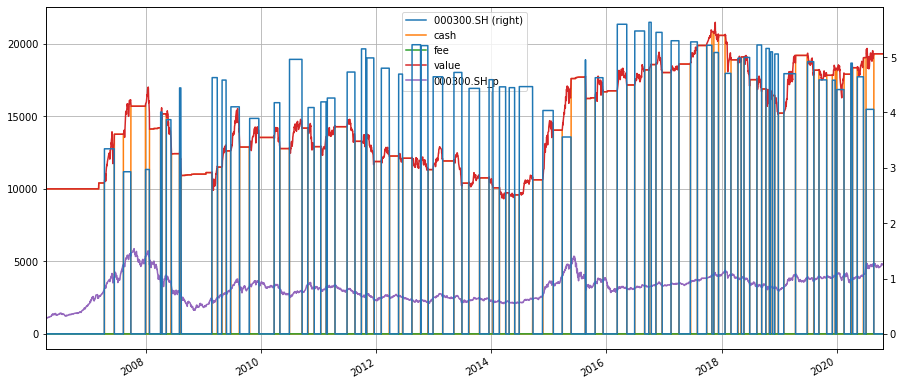

In [7]:
cont.mode = 1
cont.print_log = False
qt.run(op, cont)

### 单择时策略的优化
显然，没有经过优化的参数无法得到理想的回测结果，因此我们需要进行一次优化

通过设置context对象的各个参数，我们可以设置优化方式并控制优化过程：
以下参数的含义分别如下：

- 优化方法设置为1，使用蒙特卡洛优化，对于较大的参数空间有较好的寻优能力
- 输出结果数量设置为30
- 优化过程迭代次数为1000次
- parallel参数设置为True会使用多核处理器的所有核心进行并行计算节省时间

最后开始优化，使用`perfs_dma`和`pars_dma`两个变量来存储优化结果
优化过程中会显示进度条，结束后会显示优化结果

In [8]:
cont.mode = 2
cont.opti_method = 1
cont.output_count = 30
cont.opti_method_sample_size = 1000
cont.parallel = True
perfs_dma, pars_dma = qt.run(op, cont)

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 2
      --Optimization Mode--

Optimization progress: [########################################] 1000/1000. 100.0%  best performance: 124675.916
Optimization completed, total time consumption: 1'13"905

==========SEARCHING FINISHED===============
Searching finished, 30 best results are generated
The best parameter performs 2.072 times better than the least performing result
best result: 124675.916 obtained at parameter: 
(180, 195, 18)
least result: 60160.869 obtained at parameter: 
(194, 204, 46)
complete list of performance and parameters are following, 
                             0
(194, 204, 46)    60160.868767
(87, 191, 68)     60173.871436
(127, 175, 24)    60861.484814
(125, 140, 108)   61048.202858
(141, 160, 99)    61083.670351
(167, 185, 26)    62492.484601
(138, 158, 97)    62931.704186
(147, 165, 39)    67298.379690
(87, 135, 77)     70650.608631
(137, 168, 40)    71331.2032

优化结束后，可以看到三十组最佳参数，其中最差的一组也能实现最终资产6万元以上。我们可以手动选取其中最佳的参数，再进行一次回测：

能发现终值从上次回测的1.9万暴涨至12.4万，年化收益18.9%，夏普率也上升到了0.833

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 1
      --Back-looping Mode--

|                                  |
|          LOOPING RESULT          |
|                                  |

qteasy running mode: 1 - History back looping
time consumption for operate signal creation: 86.8ms ms
time consumption for operation back looping: 92.9ms ms

investment starts on 2006-04-03 00:00:00
ends on 2020-10-20 00:00:00
Total looped periods: 14.6 years.
operation summary:
            sell  buy  total
000300.SH    55   53    108
Total operation fee:     ¥   5,089.22
total investment amount: ¥  10,000.00
final value:             ¥ 124,675.92
Total return: 1246.759% 
Average Yearly return rate:  18.865%
Total reference return: 344.118% 
Average Yearly reference return rate: 10.783%
strategy performance indicators: 
alpha:               0.083
Beta:                0.982
Sharp ratio:         0.833
Info ratio:          0.016
250 day volatility:  0.

0.8329162967071512

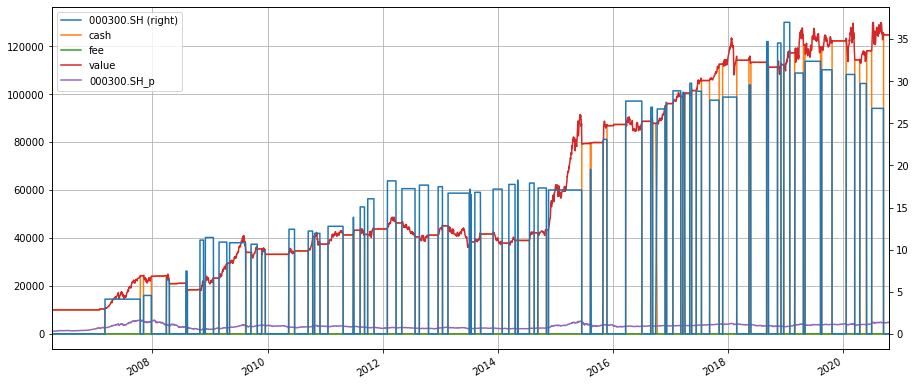

In [9]:
cont.mode = 1
op.set_parameter('t-0', pars=(180, 195, 18))
qt.run(op, cont)

### 择时策略的进一步改进——多重择时
由于择时策略具备一定的随机性，在历史过程中某一个策略并不会总是表现好，而会时而表现好，时而表现差，因此，如果我们同时使用多个参数不同的策略来共同生成择时买卖信号，这样能够形成类似于“委员会”的效果，可能使择时信号在整个时段上都表现较好。

下面，我们就可以创建这样一个多重择时策略，通过多个策略的平均信号或多重信号来进行买卖，看看相对于单一择时策略，能有多少性能提升。

#### 建立多重择时策略

我们可以建立一个包含8个相同的DMA择时策略的operator对象，并对它进行参数设置。

为了在优化过程中充分利用上一步优化的结果，我们可以设置策略的opt_tag参数为2，并将上一次找到的三十组较优参数设置为参数空间，这样下一次优化的时候，将仅从上次优化的结果中选取参数，而忽略其他的参数。

同样设置好基本参数后，可以直接开始优化过程（优化过程忽略）
优化后，我们找到了一组最优参数组，这个参数组中包含了八组DMA参数，需要分别将这八组参数分别赋予operator对象中的八个DMA择时策略

In [11]:
print(f'===============SEARCHING FOR COMBINED PARAMS==================\n'
      f'==============================================================')
op = qt.Operator(timing_types=['dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma'],
                 selecting_types=['all'], ricon_types=['urgent'])
op.set_parameter('s-0', pars=(2,), sample_freq='y')
op.set_parameter('t-0', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-1', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-2', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-3', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-4', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-5', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-6', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-7', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])

op.set_blender('ls', 'none')
op.set_parameter(stg_id='t-0', pars=(143, 153, 74))
op.set_parameter(stg_id='t-1', pars=(145, 201, 25))
op.set_parameter(stg_id='t-2', pars=(145, 161, 53))
op.set_parameter(stg_id='t-3', pars=(105, 132, 95))
op.set_parameter(stg_id='t-4', pars=(103, 118, 70))
op.set_parameter(stg_id='t-5', pars=(96, 108, 72))
op.set_parameter(stg_id='t-6', pars=(108, 121, 94))
op.set_parameter(stg_id='t-7', pars=(139, 141, 115))
op.set_parameter('r-0', pars=(8, -0.1443033))

===============SEARCHING FOR COMBINED PARAMS==================


### 最终结果
设置好优化完成的参数后，进行一次回测，检查结果：

与单个DMA策略的最终结果相比，多重择时策略的提升是巨大的：

资产终值达到了39.7万元，年化收益达到了28.7%，夏普率达到了1.877！
充分说明了多重择时策略的优良性能

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 1
      --Back-looping Mode--



../qteasy/utilfuncs.py:57: RuntimeWarning: invalid value encountered in less
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)
../qteasy/utilfuncs.py:57: RuntimeWarning: divide by zero encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)
../qteasy/utilfuncs.py:57: RuntimeWarning: invalid value encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)


|                                  |
|          LOOPING RESULT          |
|                                  |

qteasy running mode: 1 - History back looping
time consumption for operate signal creation: 601.2ms ms
time consumption for operation back looping: 168.9ms ms

investment starts on 2006-04-03 00:00:00
ends on 2020-10-20 00:00:00
Total looped periods: 14.6 years.
operation summary:
            sell  buy  total
000300.SH    96   96    192
Total operation fee:     ¥  19,991.12
total investment amount: ¥  10,000.00
final value:             ¥ 397,159.90
Total return: 3971.599% 
Average Yearly return rate:  28.682%
Total reference return: 344.118% 
Average Yearly reference return rate: 10.783%
strategy performance indicators: 
alpha:               0.180
Beta:                1.000
Sharp ratio:         1.877
Info ratio:          0.043
250 day volatility:  0.134
Max drawdown:        26.971% on 2008-09-17 00:00:00

===========END OF REPORT=============



1.8774782585371528

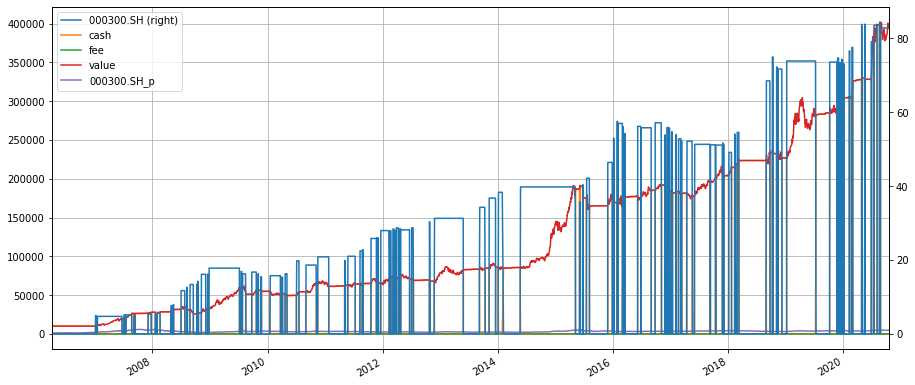

In [12]:
cont.mode = 1
cont.opti_method = 1
cont.opti_method_sample_size = 1000
cont.opti_method_step_size = 1
cont.print_log = False
qt.run(op, cont)